In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from __future__ import print_function
import numpy
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import scipy

from pathlib import Path
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

2022-10-26 11:38:35.137763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 11:38:35.273534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 11:38:35.857046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-10-26 11:38:35.857963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [62]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 256
image_width = 256

images_path = '../images'
batch_size = 16

train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training',
    # seed=seed,
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation',
    # seed=seed,
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = preprocess_img(batch[i])
        yield batch_crops, batch_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


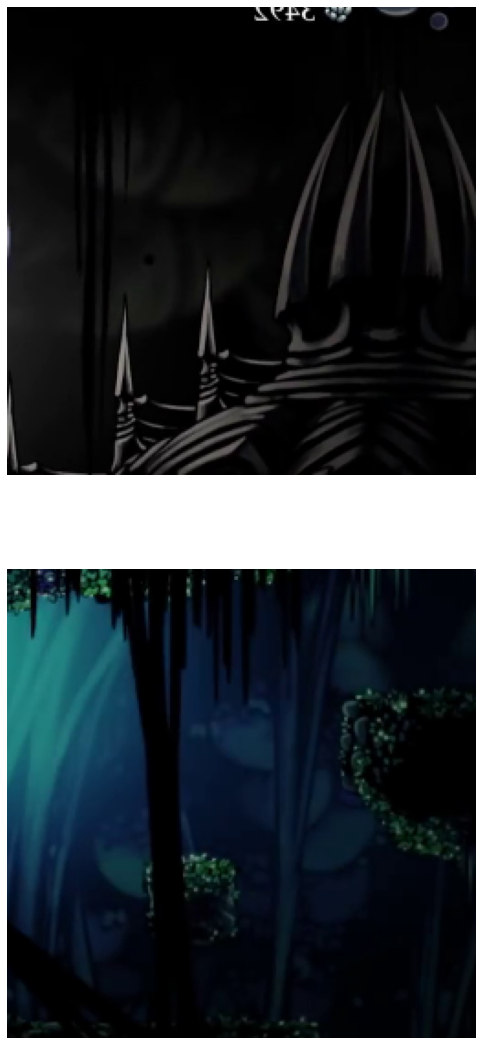

In [63]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [64]:

from keras import Sequential
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, UpSampling2D, Conv2D, LeakyReLU, Conv2DTranspose, ZeroPadding2D, BatchNormalization, \
    Dropout, Activation


def create_model_mobilenet():
    conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = Sequential(conv_base.layers[:-15])

    model.add(Conv2D(128, kernel_size=(1, 1), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, name='encoded', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    return model, conv_base


def create_model_vgg16():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = Sequential(conv_base.layers[:-1])

    model.add(Conv2D(32, kernel_size=(1, 1), padding='same', kernel_initializer='he_normal'))
    # # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))
    #
    # model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))
    #
    # model.add(Conv2D(32, name='encoded', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))


    # model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))
    model.add(Dropout(.2))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))
    model.add(Dropout(.2))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # #model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # #model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))
    model.add(Dropout(.2))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    return model, conv_base

# create_model()[1].summary()
# create_model()[0].summary()

In [73]:
import tensorflow


def ssim_loss(y_true, y_pred):
    # print(f'y_true: {y_true}')
    # print(f'y_pred: {y_pred}')
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))


model, conv_base = create_model_vgg16()
# model = create_improved_baseline_model_4x_comp()

# total_num_layers = len(model.layers)
# num_base_layers = len(conv_base.layers)
# print(f"Total number of layers is {total_num_layers}")
# print(f"Number of pretrained base layers is {num_base_layers}")



conv_base.trainable = False
# for layer in model.layers:
#     layer.trainable = False

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)     

In [74]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [75]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=ssim_loss)

In [76]:
# Train model
model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=10,
                verbose=1)

Epoch 1/10
212/212 [==============================] - 64s 290ms/step - loss: 0.4343 - val_loss: 0.3810
Epoch 2/10
212/212 [==============================] - 60s 282ms/step - loss: nan - val_loss: nan
Epoch 3/10
 33/212 [===>..........................] - ETA: 40s - loss: nan

KeyboardInterrupt: 

Epoch 1/3
106/106 [==============================] - 39s 371ms/step - loss: 0.0921 - val_loss: 0.1045
Epoch 2/3
106/106 [==============================] - 42s 397ms/step - loss: 0.0909 - val_loss: 0.1039
Epoch 3/3
106/106 [==============================] - 42s 400ms/step - loss: 0.0882 - val_loss: 0.1025

In [54]:
# model.save('../model-saves/pretrained/')

INFO:tensorflow:Assets written to: ../model-saves/pretrained/assets


INFO:tensorflow:Assets written to: ../model-saves/pretrained/assets


1/1 [==============================] - 1s 758ms/step


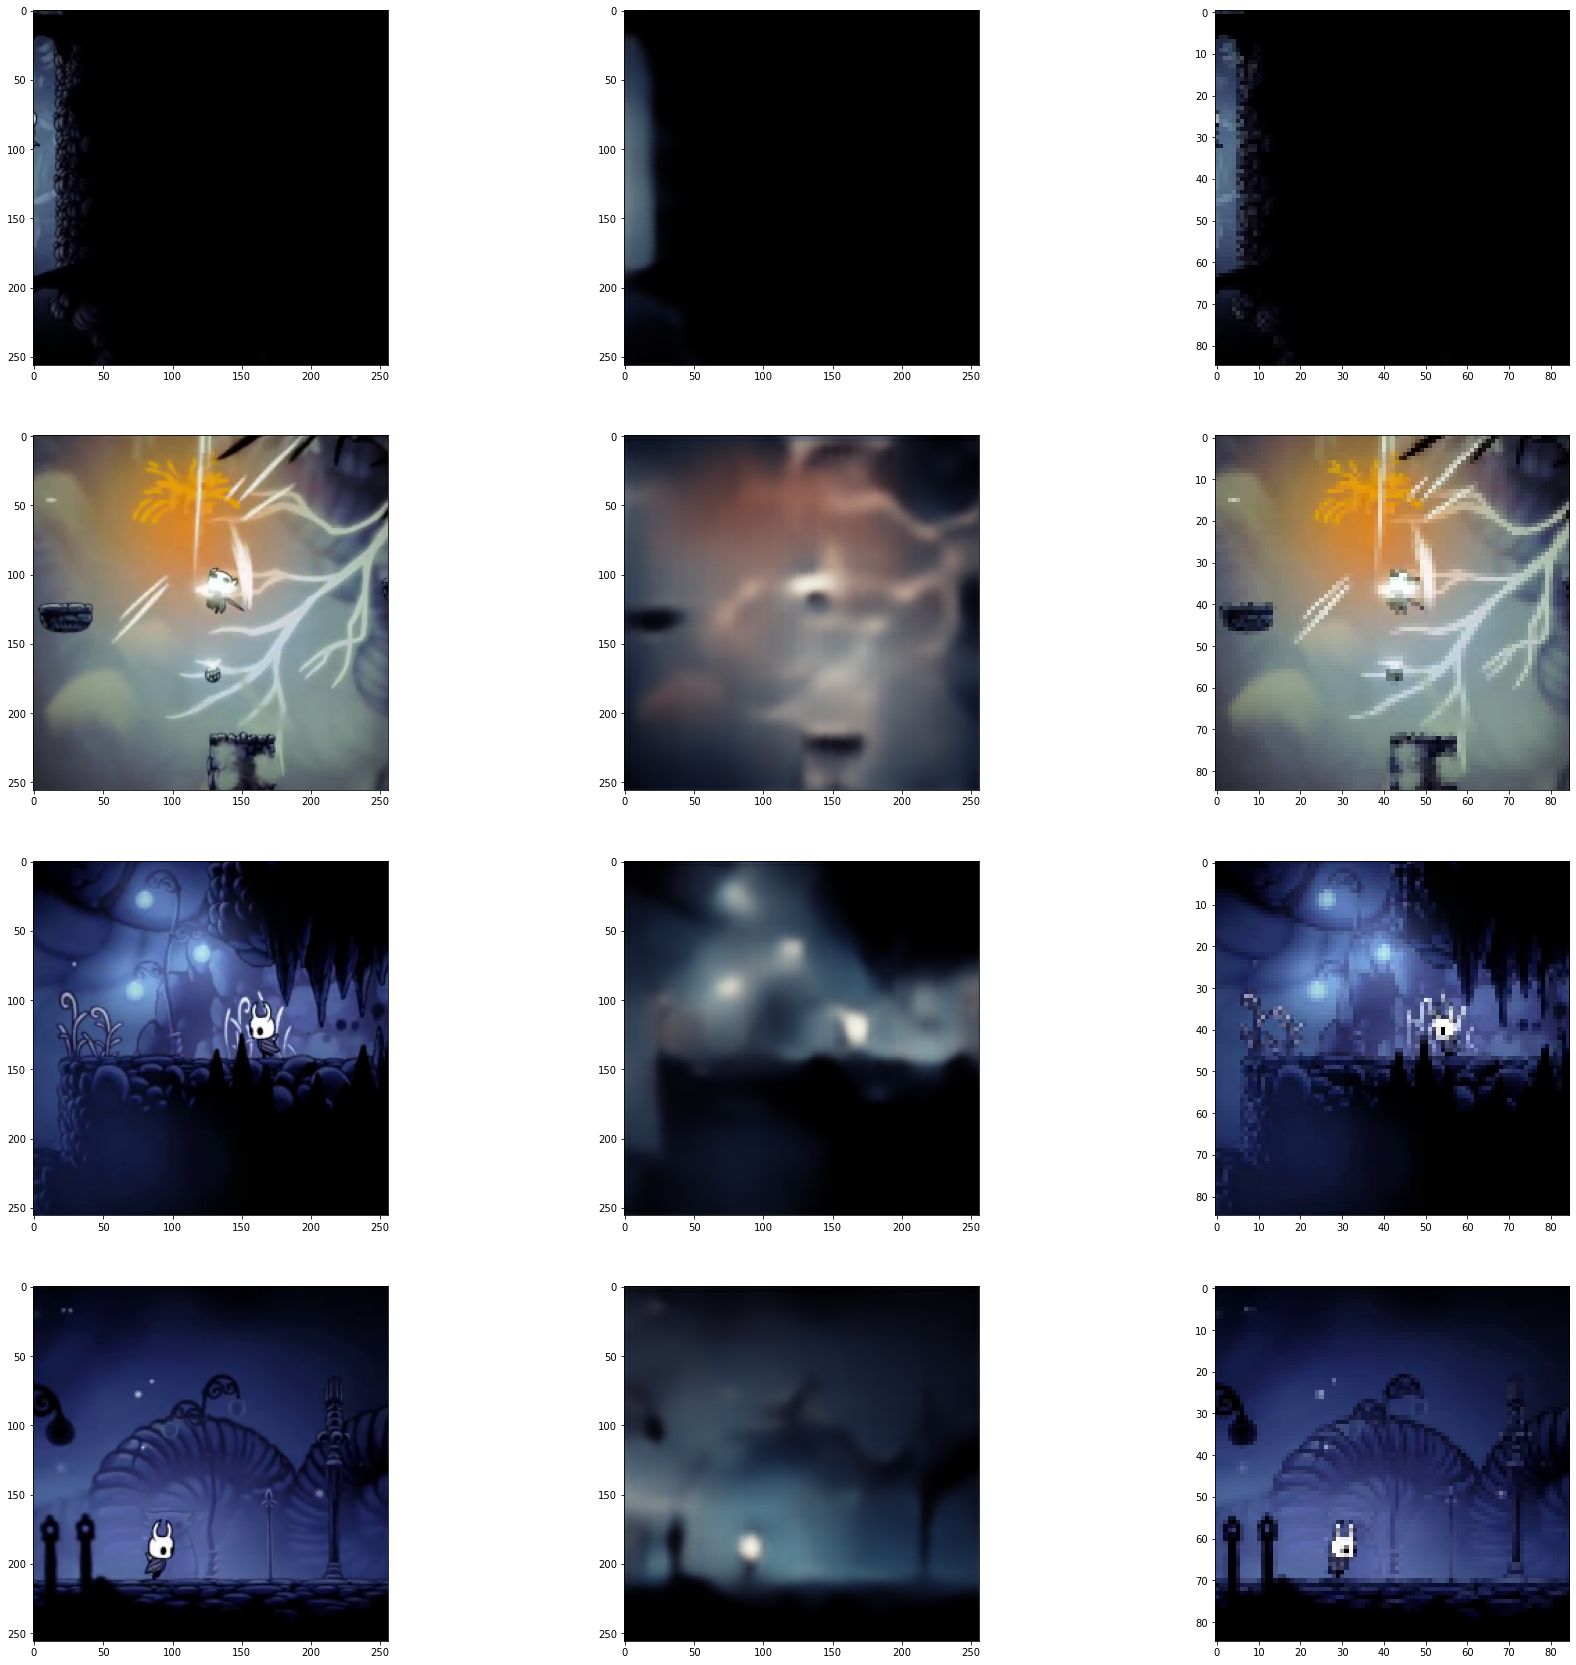

In [21]:
from matplotlib.pyplot import axes
import numpy as np
import cv2

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = model.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(in_img, (in_img.shape[0] // 3, in_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')